In [1]:
from __future__ import print_function

from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
from optparse import OptionParser
import sys
from time import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler


from scipy.sparse.linalg import svds
import utils

from string import punctuation
from sklearn.feature_extraction import text
from nltk.corpus import stopwords
import nltk

try:
    import cPickle as pickle
except ImportError:
    import pickle

In [2]:
categories = ['comp.graphics','comp.os.ms-windows.misc','comp.sys.ibm.pc.hardware','comp.sys.mac.hardware','rec.autos','rec.motorcycles','rec.sport.baseball','rec.sport.hockey']
dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True,random_state=42)

In [3]:
print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))

7882 documents
8 categories


In [4]:
# stopping word

stop_words_skt = text.ENGLISH_STOP_WORDS

nltk.download('stopwords' )
stop_words_en = stopwords.words('english')

combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shuangyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
vectorizer = TfidfVectorizer(min_df=3, stop_words=combined_stopwords) 
X = vectorizer.fit_transform(dataset.data) # TF 

tfidf_transformer = TfidfTransformer()
X_tfidf  = tfidf_transformer.fit_transform(X)#TFIDF

## Problem 1

In [11]:
X_tfidf = pickle.load(open("X_tfidf.dat", "rb"))

In [6]:

print('The size of TF/TFIDF: ',X_tfidf.shape)


The size of TF/TFIDF:  (7882, 27743)


In [7]:
km = KMeans(n_clusters=2, init='k-means++', max_iter=100,random_state=42)
print("Clustering sparse data with :\n  %s" % km)
t0 = time()
km.fit(X_tfidf)
print("done in %0.3fs" % (time() - t0))

Clustering sparse data with :
  KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=42, tol=0.0001, verbose=0)
done in 64.727s


In [8]:
labels = dataset.target
labels = (labels >3)

utils.cluster_score(labels,km.labels_,p = True)

Homogeneity: 0.264
Completeness: 0.344
V-measure: 0.298
Adjusted Rand-Index: 0.191
mutual_info_score: 0.183


[0.2636912573942426,
 0.34385330270683967,
 0.29848381733462964,
 0.19060488852725122,
 0.1827645933987022]

Confusion matrix, without normalization
[[3901    2]
 [2218 1761]]


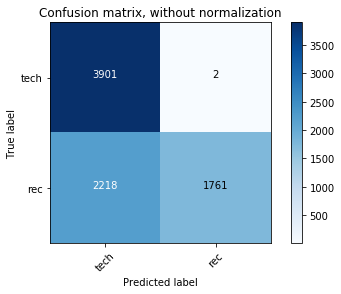

In [9]:
cnf_matrix = metrics.confusion_matrix(labels, km.labels_)
utils.plot_confusion_matrix(cnf_matrix, classes=['tech','rec'],
                      title='Confusion matrix, without normalization')

## Problem 3
-----------
### 1)


In [33]:
# np.random.seed(seed=0)

In [34]:
SVD = TruncatedSVD(n_components=1000, random_state=42)
X_LSI = SVD.fit_transform(X_tfidf)
var = SVD.explained_variance_

# save to local
pickle.dump(X_tfidf, open("X_tfidf.dat", "wb"), True)
pickle.dump(X_LSI, open("X_LSI.dat", "wb"), True)
pickle.dump(var, open("var.dat", "wb"), True)

In [10]:
X_LSI = pickle.load(open("X_LSI.dat","rb"))

Text(0,0.5,'variance')

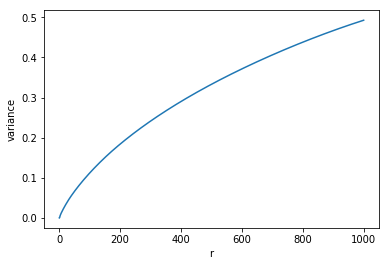

In [36]:
# var = pickle.load(open("var.dat", "rb"))
r_result = [sum(var[:i])for i in range(1001) ]
plt.plot(r_result)
plt.xlabel('r')
plt.ylabel('variance')
# plt.savefig("plots/singular_values_part3.png", format='png')

### 2) LSI

In [50]:
rs = [1,2,3,4,10,50,100,300]

----- 1 -----
Confusion matrix, without normalization
[[2466 1437]
 [2635 1344]]
Homogeneity: 0.001
Completeness: 0.001
V-measure: 0.001
Adjusted Rand-Index: 0.001
mutual_info_score: 0.001
----- 2 -----
Confusion matrix, without normalization
[[  15 3888]
 [2182 1797]]
Homogeneity: 0.334
Completeness: 0.392
V-measure: 0.361
Adjusted Rand-Index: 0.292
mutual_info_score: 0.232
----- 3 -----
Confusion matrix, without normalization
[[3902    1]
 [2429 1550]]
Homogeneity: 0.227
Completeness: 0.317
V-measure: 0.264
Adjusted Rand-Index: 0.147
mutual_info_score: 0.157
----- 4 -----
Confusion matrix, without normalization
[[   2 3901]
 [1512 2467]]
Homogeneity: 0.219
Completeness: 0.310
V-measure: 0.257
Adjusted Rand-Index: 0.139
mutual_info_score: 0.152
----- 10 -----
Confusion matrix, without normalization
[[   2 3901]
 [1643 2336]]
Homogeneity: 0.242
Completeness: 0.328
V-measure: 0.278
Adjusted Rand-Index: 0.165
mutual_info_score: 0.168
----- 50 -----
Confusion matrix, without normalization

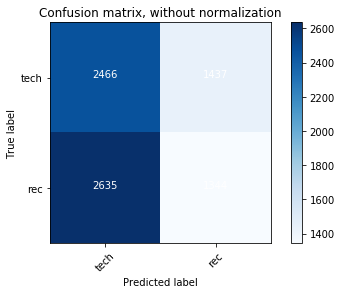

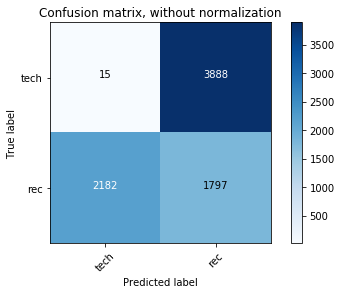

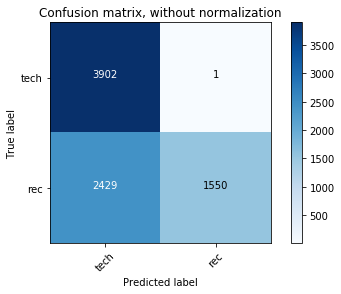

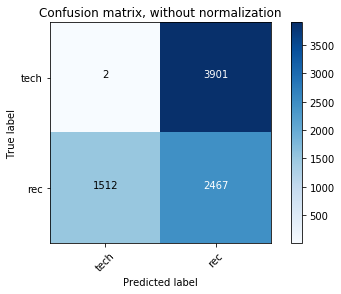

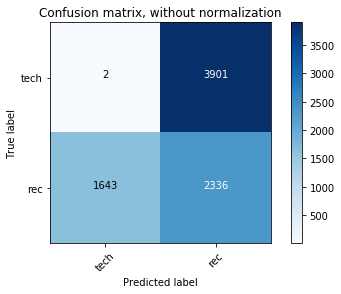

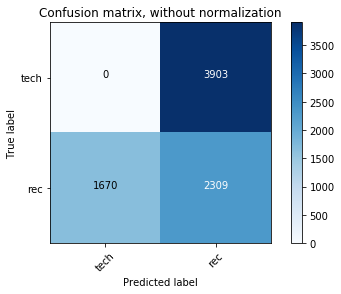

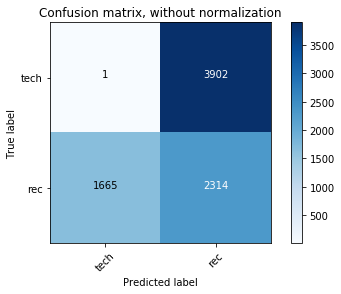

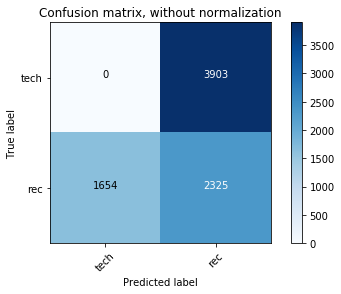

In [51]:

scores_LSI = []

t0 = time()

for r in range(1,301):
    X_truncated = X_LSI[:,:r]
    km_truncated = KMeans(n_clusters=2, init='k-means++',max_iter=100,random_state=42, n_init=30)
    km_truncated.fit(X_truncated)
    
    labels = dataset.target
    labels = (labels>3)
    
    if r in rs:
        print("-"*5,r,"-"*5)
        cnf_matrix = metrics.confusion_matrix(labels, km_truncated.labels_)
        utils.plot_confusion_matrix(cnf_matrix, classes=['tech','rec'],
                      title='Confusion matrix, without normalization')
        
        scores_LSI.append(utils.cluster_score(labels,km_truncated.labels_,p = True))
        
    else:
        scores_LSI.append(utils.cluster_score(labels,km_truncated.labels_,p = False))

print("done in %0.3fs" % (time() - t0))
        

In [3]:
# save to local
# pickle.dump(scores_LSI, open("scores_LSI.dat", "wb"), True)
scores_LSI = pickle.load(open("scores_LSI.dat", "rb"))

Text(0,0.5,'scores')

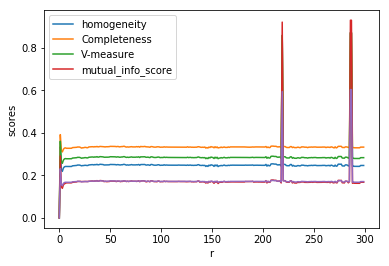

In [53]:
plt.plot(scores_LSI)
plt.legend(['homogeneity','Completeness','V-measure','mutual_info_score'])
plt.xlabel('r')
plt.ylabel('scores')


### 2) NMF

In [54]:
nmf = NMF(n_components=300, init='random', random_state=42)
X_NMF = nmf.fit_transform(X_tfidf)
pickle.dump(X_NMF, open("X_NMF.dat", "wb"), True)

----- 1 -----
Confusion matrix, without normalization
[[3799  104]
 [3979    0]]
Homogeneity: 0.014
Completeness: 0.133
V-measure: 0.025
Adjusted Rand-Index: 0.001
mutual_info_score: 0.009
----- 2 -----
Confusion matrix, without normalization
[[3903    0]
 [3959   20]]
Homogeneity: 0.003
Completeness: 0.098
V-measure: 0.005
Adjusted Rand-Index: -0.000
mutual_info_score: 0.002
----- 3 -----
Confusion matrix, without normalization
[[3903    0]
 [3959   20]]
Homogeneity: 0.003
Completeness: 0.098
V-measure: 0.005
Adjusted Rand-Index: -0.000
mutual_info_score: 0.002
----- 4 -----
Confusion matrix, without normalization
[[3903    0]
 [3959   20]]
Homogeneity: 0.003
Completeness: 0.098
V-measure: 0.005
Adjusted Rand-Index: -0.000
mutual_info_score: 0.002
----- 10 -----
Confusion matrix, without normalization
[[3903    0]
 [3959   20]]
Homogeneity: 0.003
Completeness: 0.098
V-measure: 0.005
Adjusted Rand-Index: -0.000
mutual_info_score: 0.002
----- 50 -----
Confusion matrix, without normaliza

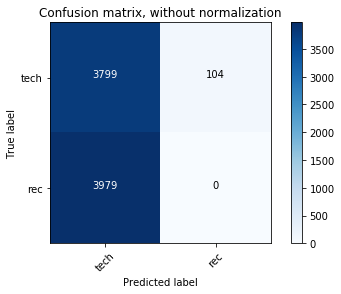

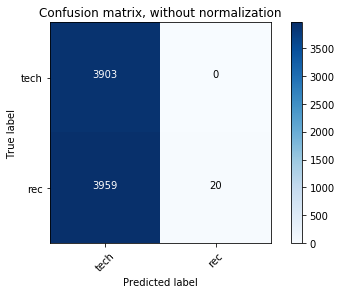

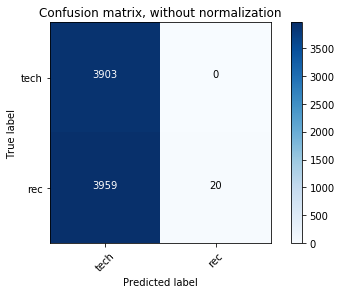

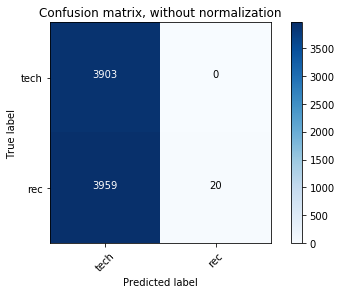

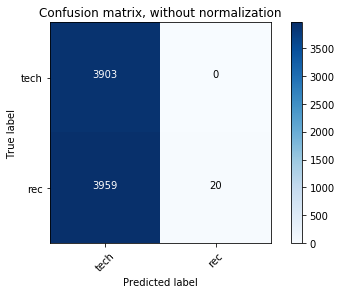

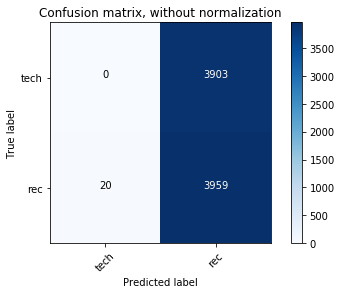

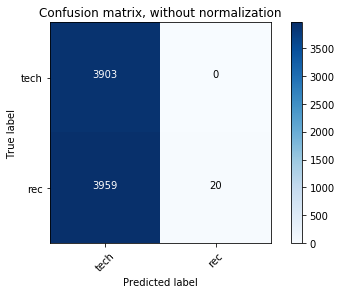

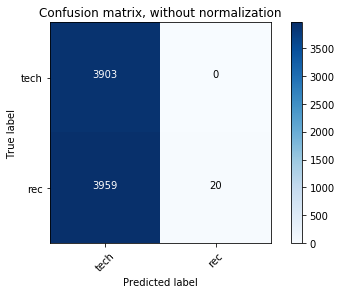

In [55]:
scores_NMF = []
for r in range(1,301):
#     np.random.seed(10)
    X_truncated = X_NMF[:,:r]
    km_truncated = KMeans(n_clusters=2, init='k-means++',random_state=42, n_init=30)
#     t0 = time()
    km_truncated.fit(X_truncated)
#     print("done in %0.3fs" % (time() - t0))
    labels = dataset.target
    labels = (labels >3)
    
    
    if r in rs:
        print("-"*5,r,"-"*5)
        cnf_matrix = metrics.confusion_matrix(labels, km_truncated.labels_)
        utils.plot_confusion_matrix(cnf_matrix, classes=['tech','rec'],
                      title='Confusion matrix, without normalization')        
        scores_NMF.append(utils.cluster_score(labels,km_truncated.labels_,p = True))
        
    else:
        scores_NMF.append(utils.cluster_score(labels,km_truncated.labels_,p = False))


In [26]:
# save to local
# pickle.dump(scores_NMF, open("scores_NMF.dat", "wb"), True)
scores_NMF = pickle.load(open("scores_NMF.dat", "rb"))

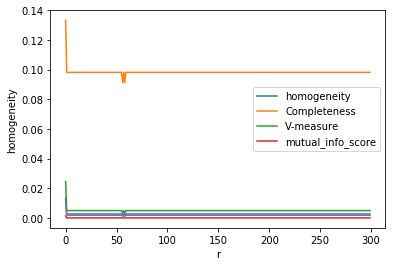

In [57]:
plt.plot(scores_NMF)
plt.xlabel('r')
plt.ylabel('homogeneity')
plt.legend(['homogeneity','Completeness','V-measure','mutual_info_score'])

#### Best LSI

Confusion matrix, without normalization
[[  15 3888]
 [2171 1808]]
Homogeneity: 0.332
Completeness: 0.390
V-measure: 0.359
Adjusted Rand-Index: 0.289
mutual_info_score: 0.230


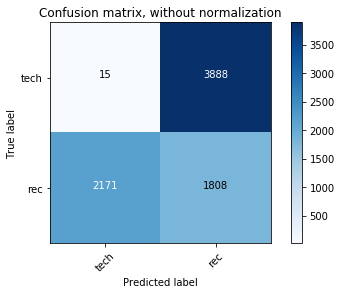

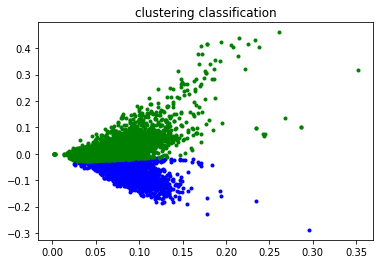

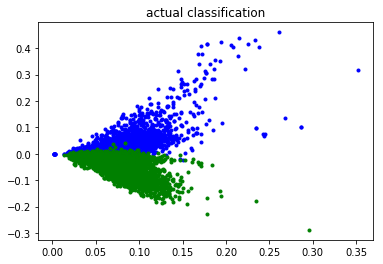

In [4]:
Best_LSI = X_LSI[:,:2]
km_best_LSI = KMeans(n_clusters=2, init='k-means++')
km_best_LSI.fit(Best_LSI)
labels = dataset.target
labels = (labels >3)
utils.compare_result(Best_LSI,labels,km_best_LSI.labels_)

#### Best NMF

Confusion matrix, without normalization
[[3903    0]
 [3959   20]]
Homogeneity: 0.003
Completeness: 0.098
V-measure: 0.005
Adjusted Rand-Index: -0.000
mutual_info_score: 0.002


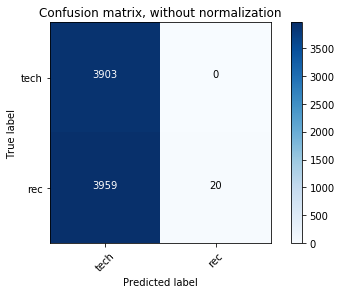

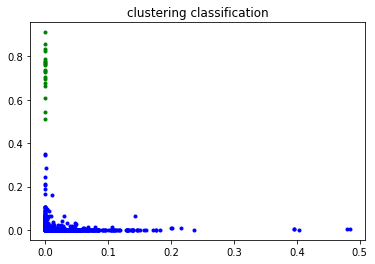

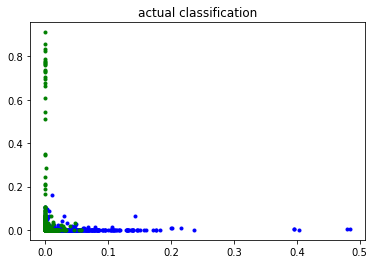

In [39]:
X_NMF = pickle.load(open("X_NMF.dat","rb"))

Best_NMF = X_NMF[:,:2]
km_best_NMF = KMeans(n_clusters=2, init='k-means++')
km_best_NMF.fit(Best_NMF)
labels = dataset.target
labels = (labels >3)
utils.compare_result(Best_NMF,labels,km_best_NMF.labels_)

### b) 
#### 1) Normalized LSI


In [49]:
X_LSI = pickle.load(open("X_LSI.dat","rb"))
X_tfidf = pickle.load(open("X_tfidf.dat", "rb"))

Confusion matrix, without normalization
[[2522 1381]
 [3864  115]]
Homogeneity: 0.142
Completeness: 0.202
V-measure: 0.166
Adjusted Rand-Index: 0.109
mutual_info_score: 0.098


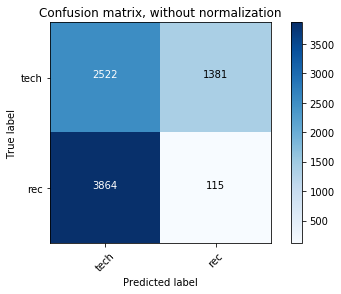

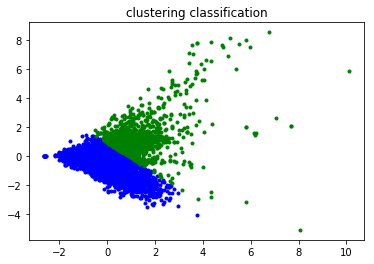

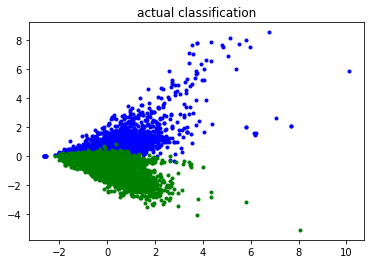

In [50]:
SVD = TruncatedSVD(n_components=2, random_state=42)
Best_LSI = SVD.fit_transform(X_tfidf)

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Best_LSI_N = scaler.fit_transform(Best_LSI)

km_best_LSI_N = KMeans(n_clusters=2, init='k-means++', random_state=42)
km_best_LSI_N.fit(Best_LSI_N)

labels = dataset.target
labels = (labels >3)

utils.compare_result(Best_LSI_N,labels,km_best_LSI_N.labels_)


#### NMF with normalization

Confusion matrix, without normalization
[[3780  123]
 [ 208 3771]]
Homogeneity: 0.751
Completeness: 0.751
V-measure: 0.751
Adjusted Rand-Index: 0.839
mutual_info_score: 0.520


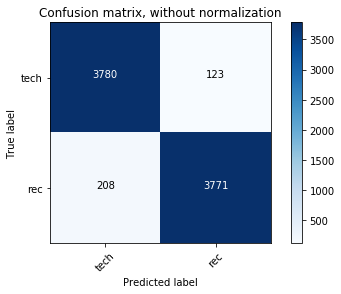

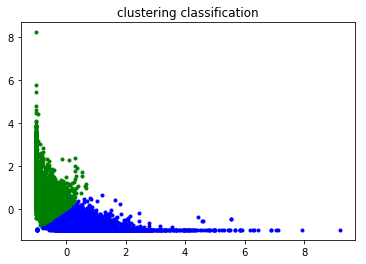

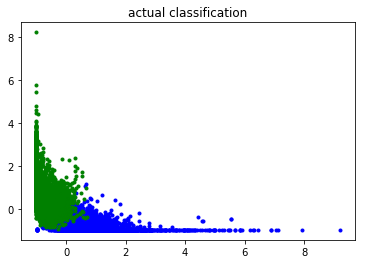

In [51]:
nmf = NMF(n_components=2, init='random', random_state=42)
Best_NMF = nmf.fit_transform(X_tfidf)

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Best_NMF_N = scaler.fit_transform(Best_NMF)

km_best_NMF_N = KMeans(n_clusters=2, init='k-means++')
km_best_NMF_N.fit(Best_NMF_N)

labels = dataset.target
labels = (labels >3)

utils.compare_result(Best_NMF_N,labels,km_best_NMF_N.labels_)

#### NMF with log transformation

Confusion matrix, without normalization
[[3752  151]
 [ 180 3799]]
Homogeneity: 0.749
Completeness: 0.749
V-measure: 0.749
Adjusted Rand-Index: 0.839
mutual_info_score: 0.519


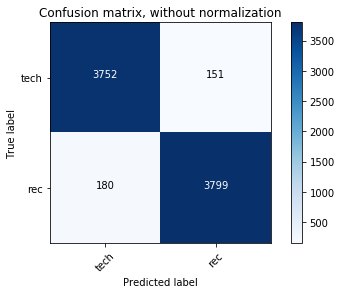

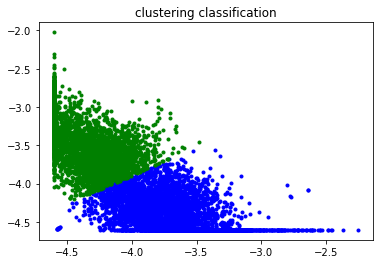

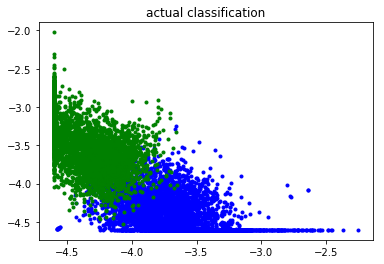

In [87]:
nmf = NMF(n_components=2, init='random', random_state=42)
Best_NMF = nmf.fit_transform(X_tfidf)


Best_NMF_log = np.log(Best_NMF+0.01)# add a offset to avoid extreme number

km_best_NMF_log = KMeans(n_clusters=2, init='k-means++')
km_best_NMF_log.fit(Best_NMF_log)

labels = dataset.target
labels = (labels >3)

utils.compare_result(Best_NMF_log,labels,km_best_NMF_log.labels_)

#### 3) Normalized -> log

Confusion matrix, without normalization
[[3773  130]
 [ 205 3774]]
Homogeneity: 0.748
Completeness: 0.748
V-measure: 0.748
Adjusted Rand-Index: 0.837
mutual_info_score: 0.518


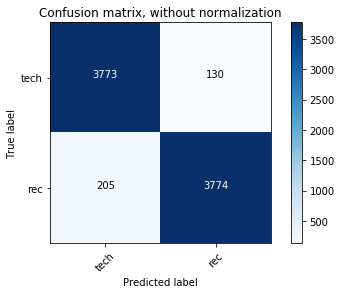

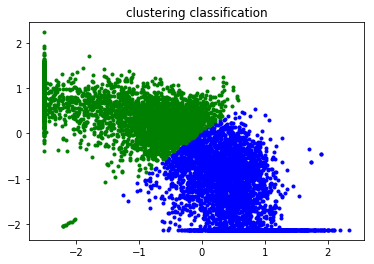

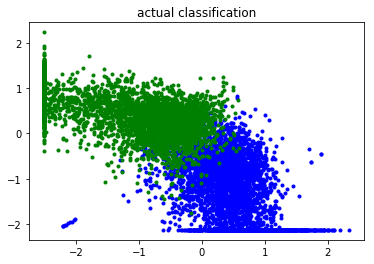

In [92]:
#normalize
nmf = NMF(n_components=2, init='random', random_state=42)
Best_NMF = nmf.fit_transform(X_tfidf)
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Best_NMF_N = scaler.fit_transform(Best_NMF)
#log
Best_NMF_NL = np.log(Best_NMF_N+1.1)#add a offset
#kmeans
km_best_NMF_NL = KMeans(n_clusters=2, init='k-means++')
km_best_NMF_NL.fit(Best_NMF_NL)

labels = dataset.target
labels = (labels >3)

utils.compare_result(Best_NMF_NL,labels,km_best_NMF_NL.labels_)

#### log -> Normalization

Confusion matrix, without normalization
[[3773  130]
 [ 205 3774]]
Homogeneity: 0.748
Completeness: 0.748
V-measure: 0.748
Adjusted Rand-Index: 0.837
mutual_info_score: 0.518


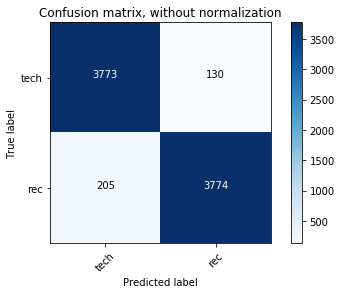

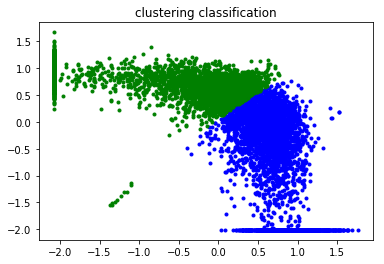

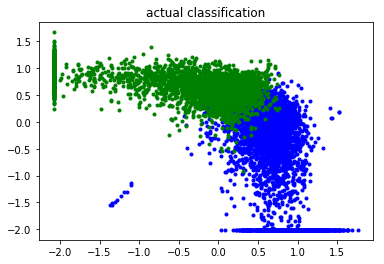

In [102]:
#log
nmf = NMF(n_components=2, init='random', random_state=42)
Best_NMF = nmf.fit_transform(X_tfidf)
Best_NMF_log = np.log(Best_NMF+0.0001)# add a offset to avoid extreme number
#Normalize

scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
Best_NMF_LN = scaler.fit_transform(Best_NMF_log)

#kmeans
km_best_NMF_LN = KMeans(n_clusters=2, init='k-means++')
km_best_NMF_LN.fit(Best_NMF_NL)

labels = dataset.target
labels = (labels >3)

utils.compare_result(Best_NMF_LN,labels,km_best_NMF_LN.labels_)

## Problem 5

### get data

In [104]:
twenty_data = fetch_20newsgroups(subset='all',shuffle=True,random_state=42)

# stopping word
stop_words_skt = text.ENGLISH_STOP_WORDS
nltk.download('stopwords' )
stop_words_en = stopwords.words('english')
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))
#TFIDF
vectorizer = TfidfVectorizer(min_df=3, stop_words=combined_stopwords) 

X_20 = vectorizer.fit_transform(twenty_data.data) # TF 
tfidf_transformer = TfidfTransformer()
X_20_tfidf  = tfidf_transformer.fit_transform(X_20)#TFIDF

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/shuangyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [105]:
X_20_tfidf.shape

(18846, 52268)

### find the reducition size

In [ ]:
# svd
SVD = TruncatedSVD(n_components=50, random_state=42)
X_20_LSI = SVD.fit_transform(X_20_tfidf)
#nmf
nmf = NMF(n_components=50, init='random', random_state=42)
X_20_NMF = nmf.fit_transform(X_20_tfidf)

In [ ]:
scores_20_LSI = []
for r in range(1,51):
    X_truncated = X_20_LSI[:,:r]
    km_truncated = KMeans(n_clusters=20, init='k-means++',max_iter=100,random_state=42)
    km_truncated.fit(X_truncated)
    
    labels = twenty_data.target
    scores_20_LSI.append(utils.cluster_score(labels,km_truncated.labels_,p = False))
    
plt.plot(scores_20_LSI)
plt.legend(['homogeneity','Completeness','V-measure','mutual_info_score'])
plt.xlabel('r')
plt.ylabel('scores')


In [ ]:
scores_20_NMF = []
for r in range(1,51):
    X_truncated = X_20_NMF[:,:r]
    km_truncated = KMeans(n_clusters=20, init='k-means++',max_iter=100,random_state=42)
    km_truncated.fit(X_truncated)
    
    labels = twenty_data.target
    scores_20_LSI.append(utils.cluster_score(labels,km_truncated.labels_,p = False))
    
plt.plot(scores_20_LSI)
plt.legend(['homogeneity','Completeness','V-measure','mutual_info_score'])
plt.xlabel('r')
plt.ylabel('scores')

